In [19]:
#!/usr/bin/env python
# validation.ipynb
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Import model components
import sys
sys.path.append("~/Project/kurucz1/")
%reload_ext autoreload
%autoreload 2
from model import AtmosphereNet, KuruczDataset
from train import custom_loss, load_dataset_file

# Load dataset
def load_validation_data(filepath, device='cpu'):
    dataset = load_dataset_file(filepath, device)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=False, num_workers=0
    )
    return dataloader, dataset

# Load model
def load_trained_model(model_path, hidden_size, depth_points, device):
    model = AtmosphereNet(
        input_size=5, 
        hidden_size=hidden_size,
        output_size=6,
        depth_points=depth_points
    ).to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint['epoch'], checkpoint['loss']

# Validate model
def validate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    param_losses = {'RHOX': 0.0, 'T': 0.0, 'P': 0.0, 
                   'XNE': 0.0, 'ABROSS': 0.0, 'ACCRAD': 0.0}
    
    all_inputs = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            all_inputs.append(inputs.cpu())
            outputs = model(inputs)
            loss, batch_param_losses = custom_loss(outputs, targets)
            
            total_loss += loss.item()
            for param, param_loss in batch_param_losses.items():
                param_losses[param] += param_loss.item()
            
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    avg_loss = total_loss / len(dataloader)
    avg_param_losses = {k: v / len(dataloader) for k, v in param_losses.items()}
    
    all_inputs = torch.cat(all_inputs, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return avg_loss, avg_param_losses, all_inputs, all_predictions, all_targets

# Calculate metrics
def calculate_metrics(predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    metrics = {}
    
    for i, param in enumerate(param_names):
        pred = predictions[:, :, i]
        targ = targets[:, :, i]
        
        mse = torch.mean((pred - targ) ** 2).item()
        rmse = np.sqrt(mse)
        mae = torch.mean(torch.abs(pred - targ)).item()
        
        ss_tot = torch.sum((targ - torch.mean(targ)) ** 2).item()
        ss_res = torch.sum((targ - pred) ** 2).item()
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        metrics[param] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }
    return metrics

In [20]:
model_path   = "/Users/jdli/Project/kurucz1/checkpoints_v0320tau/best_model.pt"
dataset_path = "/Users/jdli/Project/kurucz1/data/kurucz_vturb_0p5_tau.pt"

hidden_size = 64
device = torch.device('cpu')

# Load dataset and model
dataloader, dataset = load_validation_data(dataset_path, device)
model, epoch, train_loss = load_trained_model(
    model_path, hidden_size, dataset.max_depth_points, device
)
print(f"Model loaded: trained for {epoch} epochs, final loss: {train_loss:.6f}")

# Validate model
val_loss, param_losses, inputs, predictions, targets = validate_model(model, dataloader, device)
print(f"Validation loss: {val_loss:.6f}")
for param, loss in param_losses.items():
    print(f"{param} loss: {loss:.6f}")


Model loaded: trained for 5 epochs, final loss: 0.013594
Validation loss: 0.013663
RHOX loss: 0.003677
T loss: 0.001542
P loss: 0.003013
XNE loss: 0.001183
ABROSS loss: 0.003821
ACCRAD loss: 0.000427


In [21]:
# Calculate metrics
metrics = calculate_metrics(predictions, targets)
for param, param_metrics in metrics.items():
    print(f"\n{param} metrics:")
    for metric_name, value in param_metrics.items():
        print(f"  {metric_name}: {value:.6f}")



RHOX metrics:
  MSE: 0.001838
  RMSE: 0.042878
  MAE: 0.035062
  R²: 0.987788

T metrics:
  MSE: 0.000771
  RMSE: 0.027773
  MAE: 0.014567
  R²: 0.962843

P metrics:
  MSE: 0.001506
  RMSE: 0.038812
  MAE: 0.030863
  R²: 0.984351

XNE metrics:
  MSE: 0.001184
  RMSE: 0.034405
  MAE: 0.027178
  R²: 0.988484

ABROSS metrics:
  MSE: 0.001910
  RMSE: 0.043705
  MAE: 0.030614
  R²: 0.983924

ACCRAD metrics:
  MSE: 0.000427
  RMSE: 0.020669
  MAE: 0.015588
  R²: 0.977555


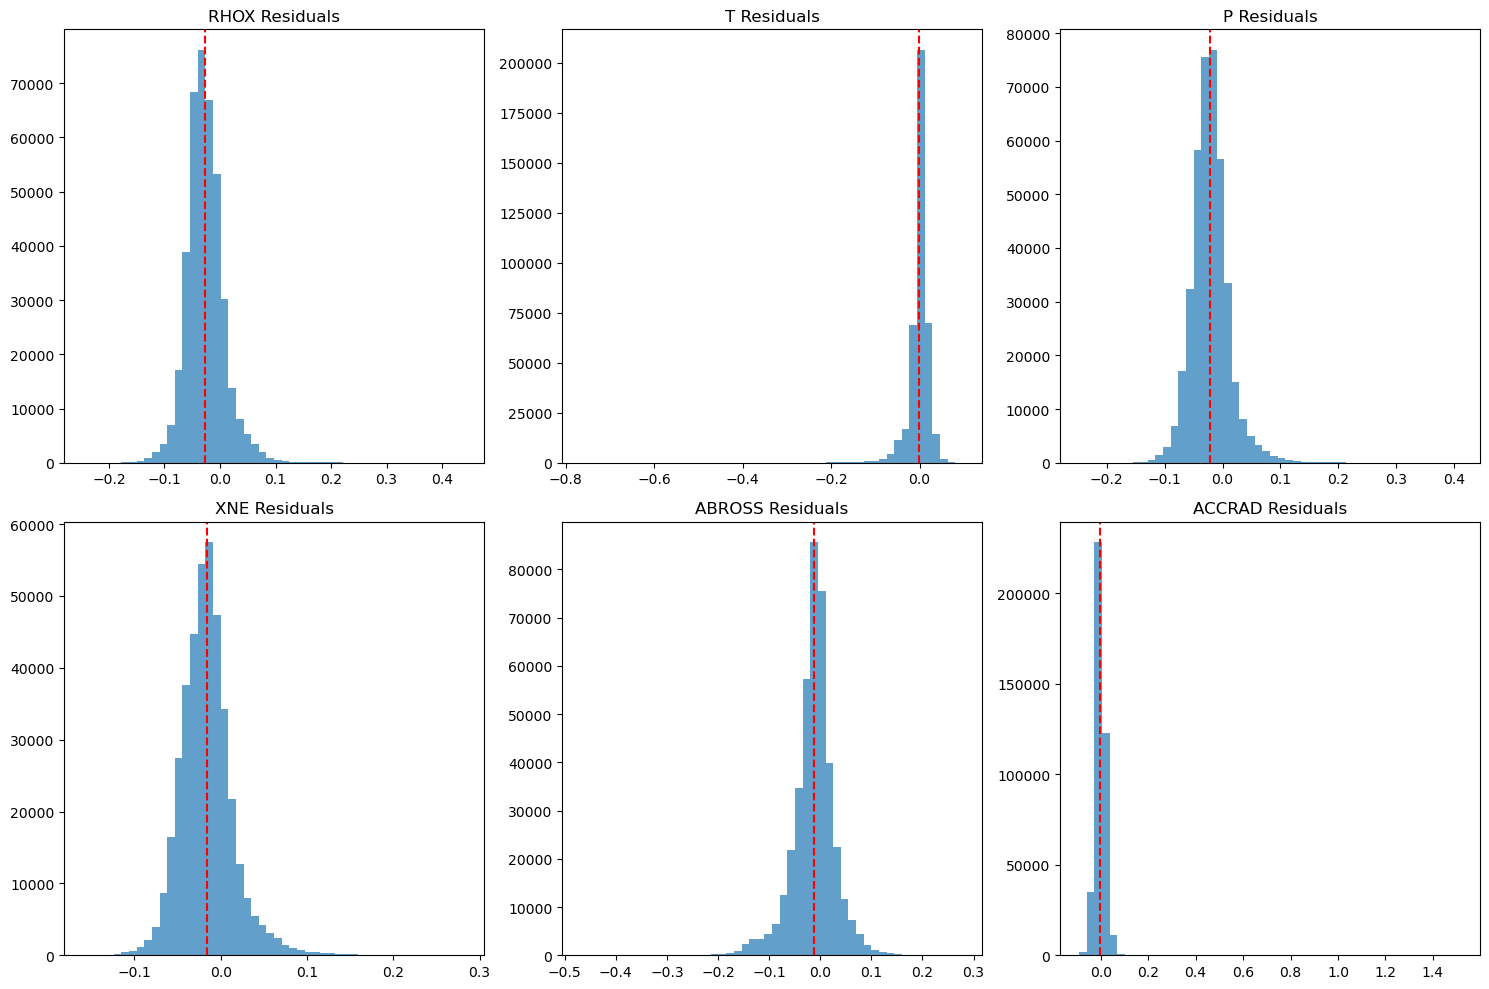

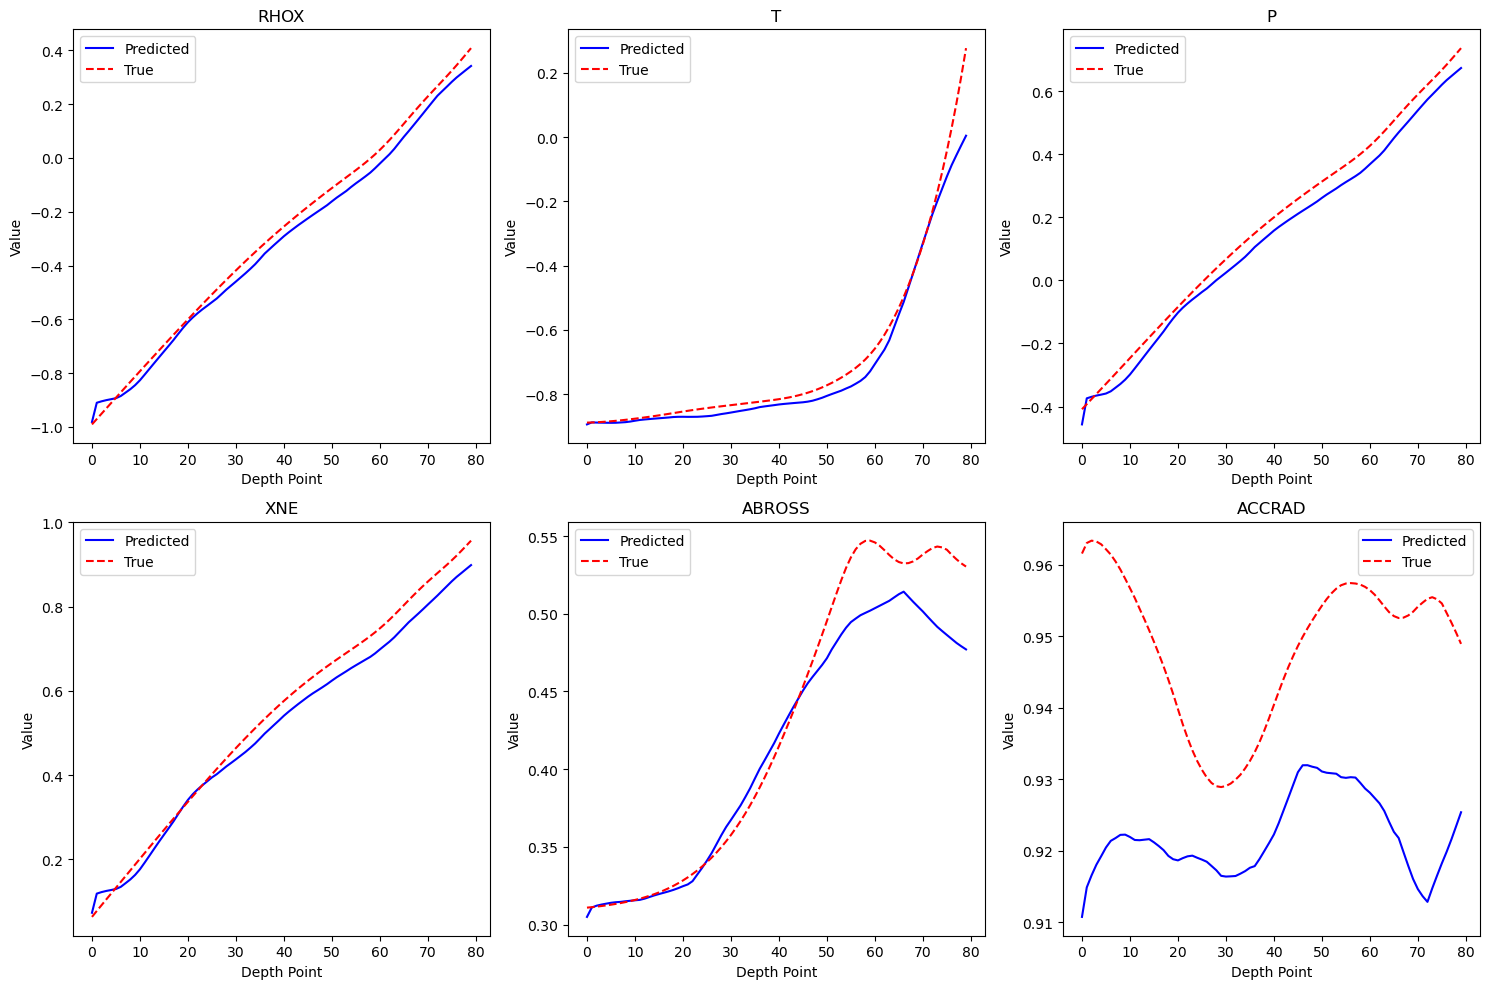

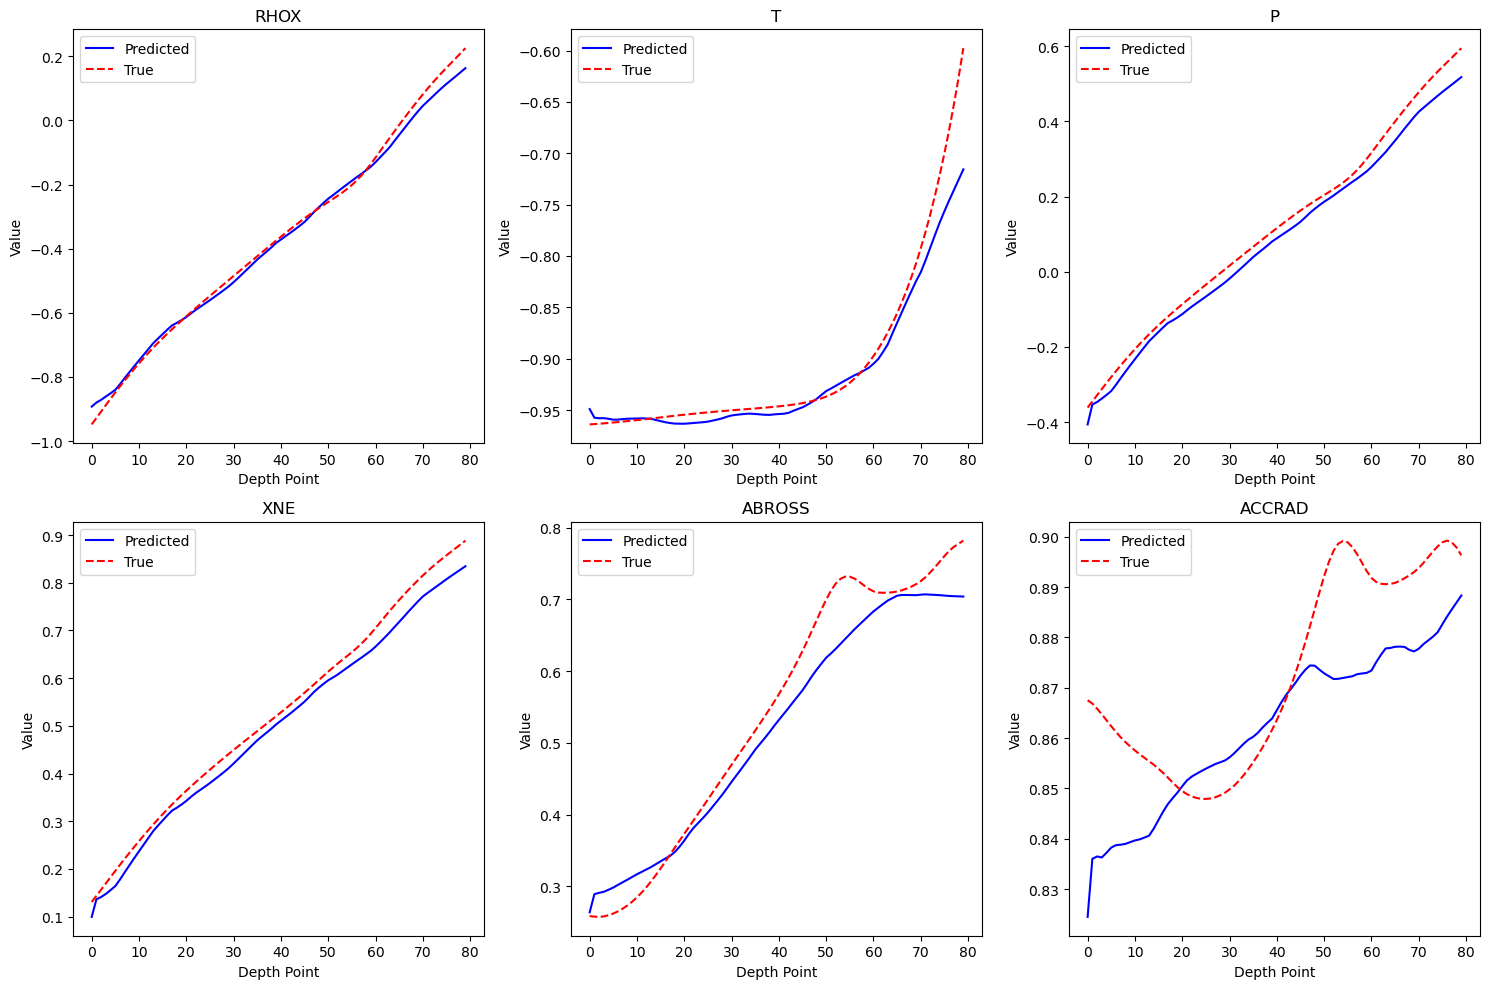

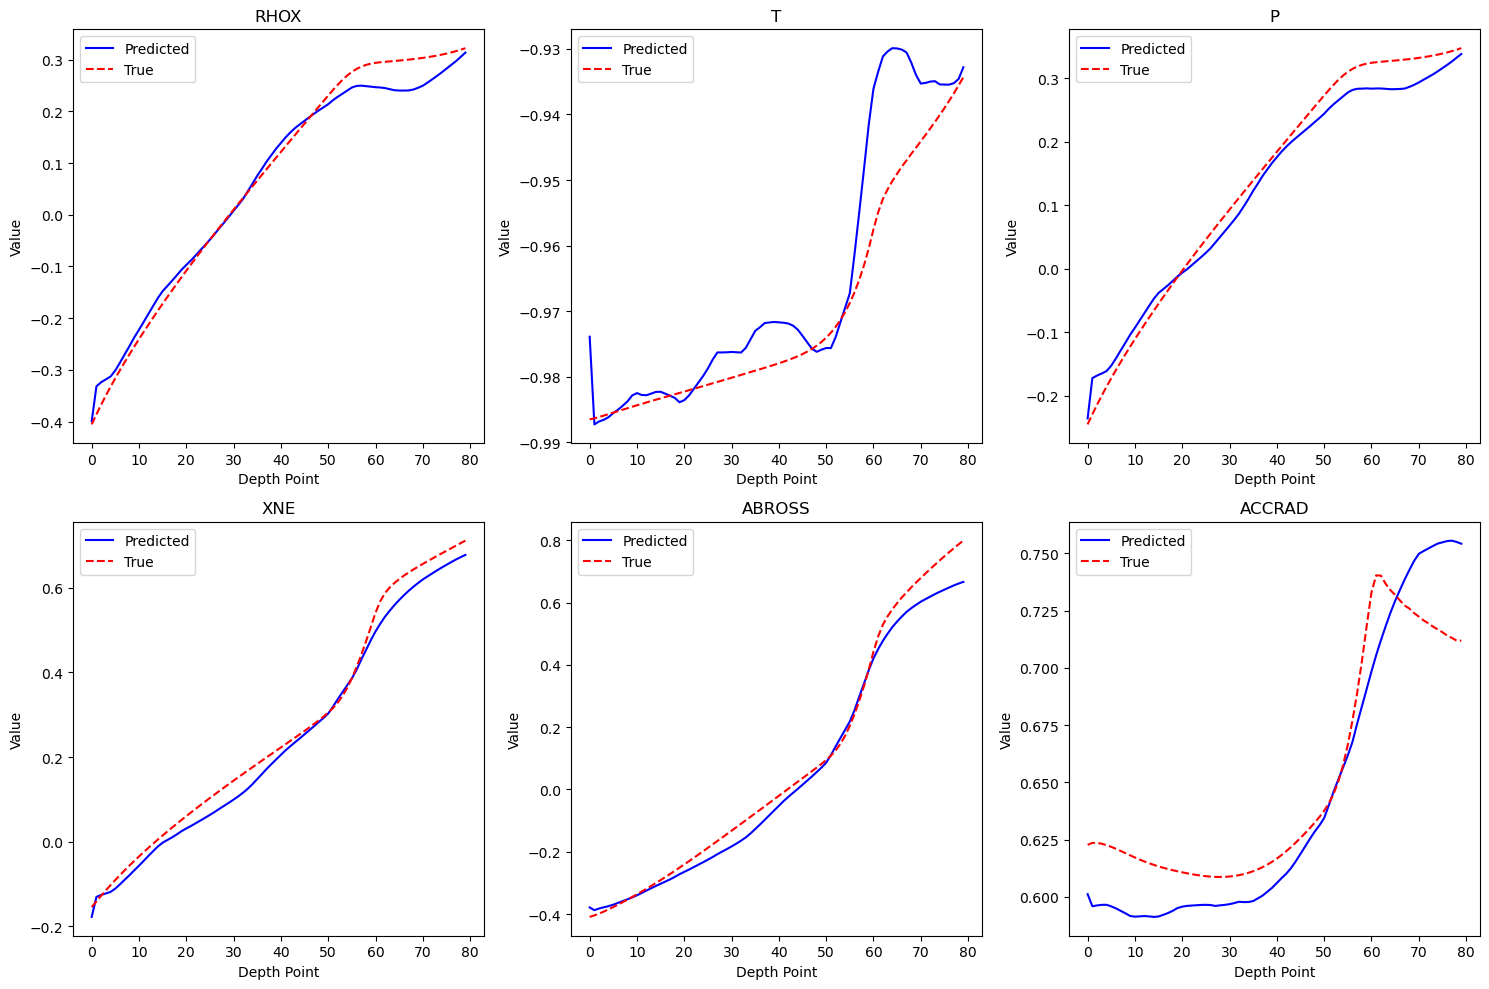

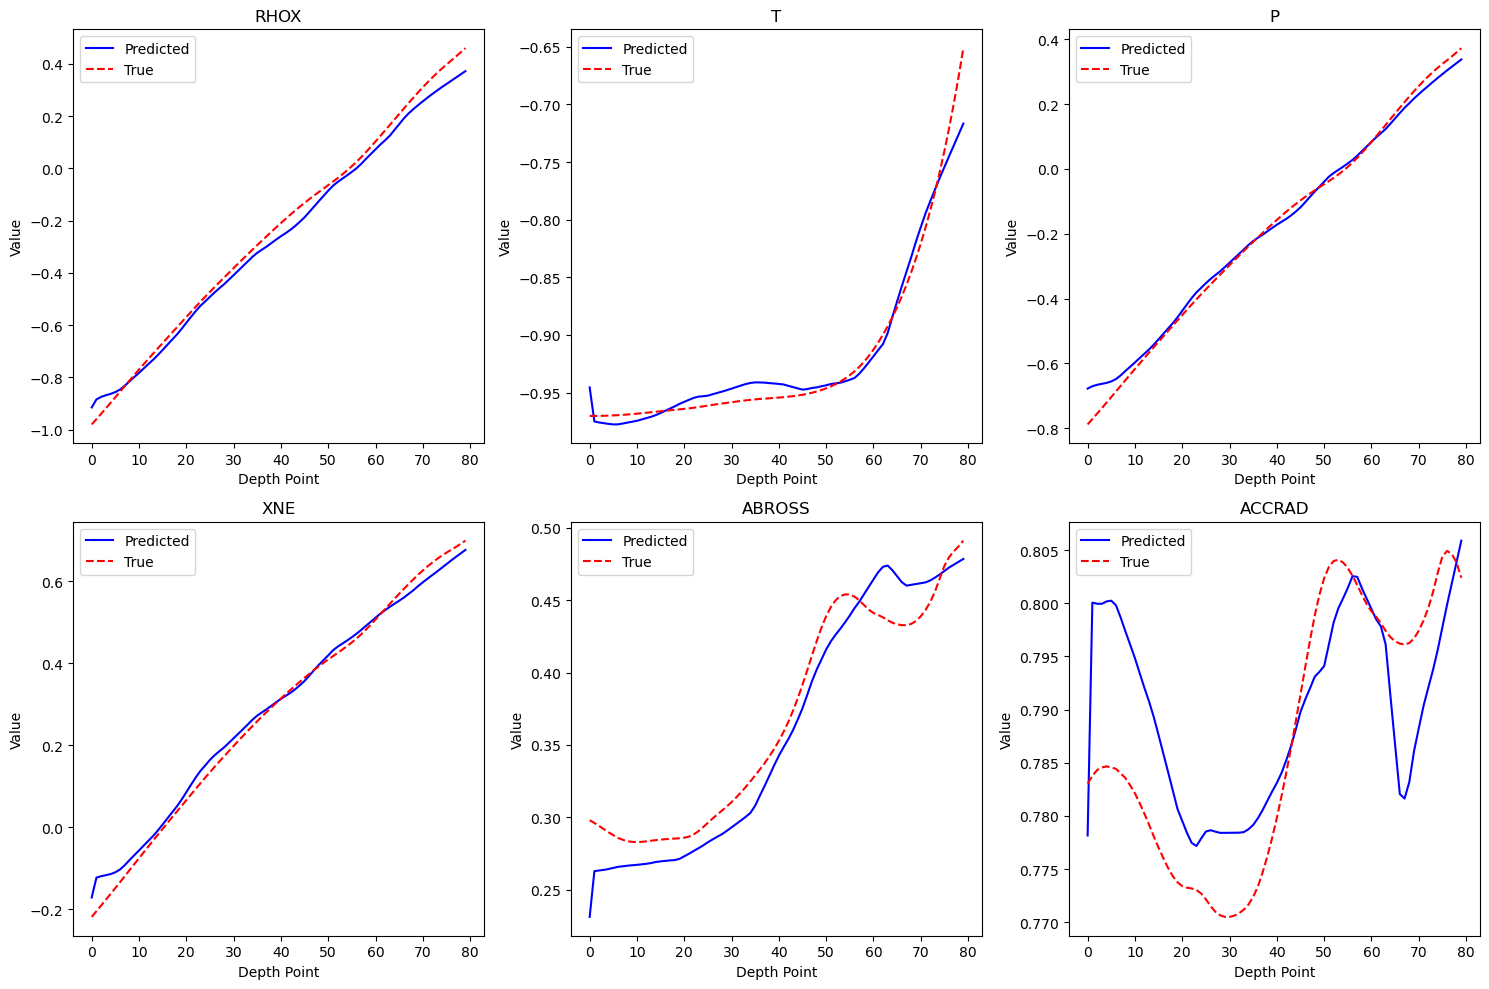

In [22]:
# --- Generate plots ---
# Plot residuals
def plot_residuals(predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    batch_size = predictions.shape[0]
    indices = torch.randperm(batch_size)[:min(5000, batch_size)]
    
    plt.figure(figsize=(15, 10))
    
    for i, param in enumerate(param_names):
        plt.subplot(2, 3, i + 1)
        
        residuals = predictions[indices, :, i] - targets[indices, :, i]
        residuals = residuals.flatten().numpy()
        
        plt.hist(residuals, bins=50, alpha=0.7)
        plt.title(f'{param} Residuals')
        plt.axvline(np.mean(residuals), color='r', linestyle='dashed')
    
    plt.tight_layout()
    return plt

residual_plot = plot_residuals(predictions, targets)

# Plot sample depth profiles
def plot_depth_profile(idx, predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    
    plt.figure(figsize=(15, 10))
    for i, param in enumerate(param_names):
        plt.subplot(2, 3, i + 1)
        
        pred_values = predictions[idx, :, i].numpy()
        true_values = targets[idx, :, i].numpy()
        depth_points = np.arange(len(pred_values))
        
        plt.plot(depth_points, pred_values, 'b-', label='Predicted')
        plt.plot(depth_points, true_values, 'r--', label='True')
        
        plt.title(f'{param}')
        plt.xlabel('Depth Point')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    return plt

# Plot a few sample profiles
sample_indices = torch.randperm(predictions.shape[0])[:4]
for idx in sample_indices:
    profile_plot = plot_depth_profile(idx, predictions, targets)

In [ ]:
def calculate_dP_dtau(model, dataset, sample_indices=None, device='cpu'):
    """
    Calculate the pressure gradient with respect to optical depth (dP/dtau)
    
    Parameters:
        model (AtmosphereNet): Trained model
        dataset (KuruczDataset): Dataset containing the atmospheric models
        sample_indices (list, optional): Indices of samples to process. If None, use all samples.
        device (str): Device to run calculations on ('cpu' or 'cuda')
        
    Returns:
        dict: Dictionary containing tau and dP/dtau values for each sample
    """
    model.eval()
    model.to(device)
    
    # If no indices provided, use all samples
    if sample_indices is None:
        sample_indices = range(len(dataset))
    
    results = {
        'tau': [],
        'dP_dtau': [],
        'teff': [],
        'gravity': [],
        'feh': [],
        'afe': []
    }
    
    with torch.no_grad():
        for idx in sample_indices:
            # Get input and target for this sample
            inputs, _ = dataset[idx]
            inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
            
            # Get model predictions
            outputs = model(inputs)
            
            # Extract tau from inputs (at index 4 of the last dimension)
            tau_normalized = inputs[0, :, 4]
            tau = dataset.denormalize('TAU', tau_normalized).cpu().numpy()
            
            # Extract pressure from outputs (at index 2 of the last dimension)
            p_normalized = outputs[0, :, 2]
            pressure = dataset.denormalize('P', p_normalized).cpu().numpy()
            
            # Calculate dP/dtau using finite differences
            dP_dtau = np.zeros_like(pressure)
            
            # Forward difference for the first point
            dP_dtau[0] = (pressure[1] - pressure[0]) / (tau[1] - tau[0])
            
            # Central differences for interior points
            for i in range(1, len(pressure) - 1):
                dP_dtau[i] = (pressure[i+1] - pressure[i-1]) / (tau[i+1] - tau[i-1])
            
            # Backward difference for the last point
            dP_dtau[-1] = (pressure[-1] - pressure[-2]) / (tau[-1] - tau[-2])
            
            # Store results
            results['tau'].append(tau)
            results['dP_dtau'].append(dP_dtau)
            
            # Store stellar parameters for reference
            stellar_params = inputs[0, 0, :4].cpu().numpy()  # First depth point, first 4 parameters
            teff = dataset.denormalize('teff', torch.tensor([stellar_params[0]], device=device)).item()
            gravity = dataset.denormalize('gravity', torch.tensor([stellar_params[1]], device=device)).item()
            feh = dataset.denormalize('feh', torch.tensor([stellar_params[2]], device=device)).item()
            afe = dataset.denormalize('afe', torch.tensor([stellar_params[3]], device=device)).item()
            
            results['teff'].append(teff)
            results['gravity'].append(gravity)
            results['feh'].append(feh)
            results['afe'].append(afe)
    
    return results


In [35]:
sample_indices = [0, 10, 20, 30]  # Choose specific samples
results_nn_grad = calculate_dP_dtau(model, dataset, sample_indices)


In [36]:
def calculate_dP_dtau_differential(model, dataset, sample_indices=None, device='cpu'):
    """
    Calculate the pressure gradient with respect to optical depth (dP/dtau)
    using the differential method with automatic differentiation.
    
    Parameters:
        model (AtmosphereNet): Trained model
        dataset (KuruczDataset): Dataset containing the atmospheric models
        sample_indices (list, optional): Indices of samples to process. If None, use all samples.
        device (str): Device to run calculations on ('cpu' or 'cuda')
        
    Returns:
        dict: Dictionary containing tau and dP/dtau values for each sample
    """
    model.eval()
    model.to(device)
    
    # If no indices provided, use all samples
    if sample_indices is None:
        sample_indices = range(len(dataset))
    
    results = {
        'tau': [],
        'dP_dtau': [],
        'teff': [],
        'gravity': [],
        'feh': [],
        'afe': []
    }
    
    for idx in sample_indices:
        # Get input for this sample
        inputs, _ = dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension
        
        # Extract stellar parameters for reference
        stellar_params = inputs[0, 0, :4].detach().cpu().numpy()
        teff = dataset.denormalize('teff', torch.tensor([stellar_params[0]], device=device)).item()
        gravity = dataset.denormalize('gravity', torch.tensor([stellar_params[1]], device=device)).item()
        feh = dataset.denormalize('feh', torch.tensor([stellar_params[2]], device=device)).item()
        afe = dataset.denormalize('afe', torch.tensor([stellar_params[3]], device=device)).item()
        
        # Get tau values (we need to track gradients for tau)
        tau_normalized = inputs[0, :, 4].clone().detach().requires_grad_(True)
        
        # Create a new input tensor with the gradient-enabled tau
        new_inputs = inputs.clone().detach()
        new_inputs[0, :, 4] = tau_normalized
        
        # Forward pass
        outputs = model(new_inputs)
        
        # Extract pressure (at index 2 of the last dimension)
        p_normalized = outputs[0, :, 2]
        
        # Calculate gradients for each depth point
        dP_dtau_normalized = []
        
        for i in range(len(p_normalized)):
            # Zero gradients
            if tau_normalized.grad is not None:
                tau_normalized.grad.zero_()
            
            # Get pressure at this depth point
            p_i = p_normalized[i]
            
            # Backward pass to get gradient
            p_i.backward(retain_graph=True)
            
            # Store gradient
            if tau_normalized.grad is not None:
                dP_dtau_normalized.append(tau_normalized.grad[i].item())
            else:
                dP_dtau_normalized.append(0.0)
        
        # Denormalize tau and convert gradients to physical units
        tau = dataset.denormalize('TAU', tau_normalized.detach()).cpu().numpy()
        
        # Convert normalized gradients to physical units
        # We need to account for the normalization scaling factors
        tau_params = dataset.norm_params['TAU']
        p_params = dataset.norm_params['P']
        
        # Scale factor for denormalization
        tau_scale = (tau_params['max'] - tau_params['min']) / 2.0
        p_scale = (p_params['max'] - p_params['min']) / 2.0
        
        # If log scale was used, we need additional conversion
        if tau_params['log_scale'] and p_params['log_scale']:
            # For log-scaled parameters, the gradient needs to be adjusted
            # dP/dtau = (dP_norm/dtau_norm) * (dp_physical/dp_norm) / (dtau_physical/dtau_norm)
            dP_dtau = []
            for i in range(len(tau)):
                # Get physical values
                p_physical = dataset.denormalize('P', torch.tensor([p_normalized[i].item()], device=device)).item()
                tau_physical = tau[i]
                
                # Convert normalized gradient to physical gradient
                # For log-scaled values: d(log10(P))/d(log10(tau)) * P / tau
                gradient_factor = p_physical / tau_physical
                dP_dtau.append(dP_dtau_normalized[i] * (p_scale / tau_scale) * gradient_factor)
        else:
            # For linear scaling, the conversion is simpler
            dP_dtau = [grad * (p_scale / tau_scale) for grad in dP_dtau_normalized]
        
        # Store results
        results['tau'].append(tau)
        results['dP_dtau'].append(np.array(dP_dtau))
        results['teff'].append(teff)
        results['gravity'].append(gravity)
        results['feh'].append(feh)
        results['afe'].append(afe)
    
    return results


results_diff_grad = calculate_dP_dtau_differential(model, dataset, sample_indices=sample_indices, device=device)

/var/folders/9x/hr77dpxn3rg_yz8dnk3q7ny97p30wx/T/ipykernel_91854/881856654.py:100: RuntimeWarning: divide by zero encountered in true_divide
  gradient_factor = p_physical / tau_physical


In [40]:

def calculate_gradient_torch(x, y):
    """
    Calculate the differential gradient (dy/dx) for given x and y tensors
    with improved numerical stability.
    
    Parameters:
        x (torch.Tensor): Independent variable tensor of shape [batch_size, depth_points]
        y (torch.Tensor): Dependent variable tensor of shape [batch_size, depth_points]
        
    Returns:
        torch.Tensor: Gradient dy/dx with same shape as input
    """
    # Ensure x has no duplicate values
    epsilon = 1e-8
    batch_size, n_points = x.shape
    
    # Initialize gradient tensor
    gradient = torch.zeros_like(y)
    
    # Compute gradients using forward difference
    for i in range(n_points - 1):
        # Ensure dx is at least epsilon to avoid division by zero
        dx = torch.clamp(x[:, i+1] - x[:, i], min=epsilon)
        dy = y[:, i+1] - y[:, i]
        gradient_i = dy / dx
        
        # Create a new tensor for this index without in-place operations
        gradient_tmp = gradient.clone()
        gradient_tmp[:, i] = gradient_i
        gradient = gradient_tmp
    
    # For the last point, repeat the last calculated gradient
    gradient_tmp = gradient.clone()
    gradient_tmp[:, -1] = gradient[:, -2]  # Use the second-to-last gradient
    gradient = gradient_tmp
    
    return gradient
    
def calculate_dP_dtau_ground_truth(dataset, sample_indices=None, device='cpu'):
    """
    Calculate the ground truth pressure gradient with respect to optical depth (dP/dtau)
    directly from the dataset.
    
    Parameters:
        dataset (KuruczDataset): Dataset containing the atmospheric models
        sample_indices (list, optional): Indices of samples to process. If None, use all samples.
        device (str): Device to run calculations on ('cpu' or 'cuda')
        
    Returns:
        dict: Dictionary containing tau and dP/dtau values for each sample
    """
    # If no indices provided, use all samples
    if sample_indices is None:
        sample_indices = range(len(dataset))
    
    results = {
        'tau': [],
        'dP_dtau': [],
        'teff': [],
        'gravity': [],
        'feh': [],
        'afe': []
    }
    
    for idx in sample_indices:
        # Get original data from dataset
        tau_normalized = dataset.TAU[idx]
        p_normalized = dataset.P[idx]
        
        # Denormalize to get physical values
        tau = dataset.denormalize('TAU', tau_normalized).cpu().numpy()
        pressure = dataset.denormalize('P', p_normalized).cpu().numpy()
        
        # Calculate dP/dtau using the gradient function
        dP_dtau = calculate_gradient_torch(
            torch.tensor(tau).unsqueeze(0), 
            torch.tensor(pressure).unsqueeze(0)
        )[0].numpy()
        
        # Store results
        results['tau'].append(tau)
        results['dP_dtau'].append(dP_dtau)
        
        # Get stellar parameters
        teff = dataset.denormalize('teff', dataset.teff[idx]).item()
        gravity = dataset.denormalize('gravity', dataset.gravity[idx]).item()
        feh = dataset.denormalize('feh', dataset.feh[idx]).item()
        afe = dataset.denormalize('afe', dataset.afe[idx]).item()
        
        results['teff'].append(teff)
        results['gravity'].append(gravity)
        results['feh'].append(feh)
        results['afe'].append(afe)
    
    return results

# Example usage:
# ground_truth = calculate_dP_dtau_ground_truth(dataset, sample_indices=[0, 10, 20])
dP_dtau_ground_truth = calculate_dP_dtau_ground_truth(dataset, sample_indices=sample_indices)

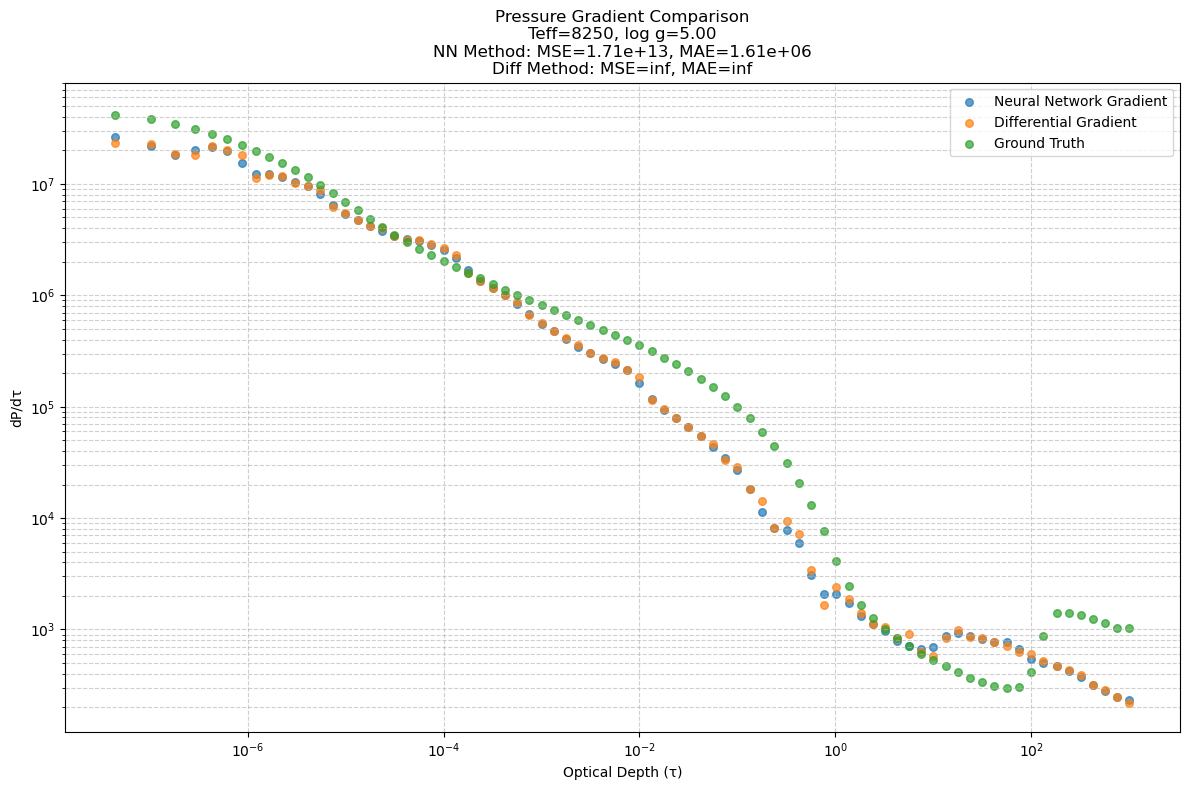

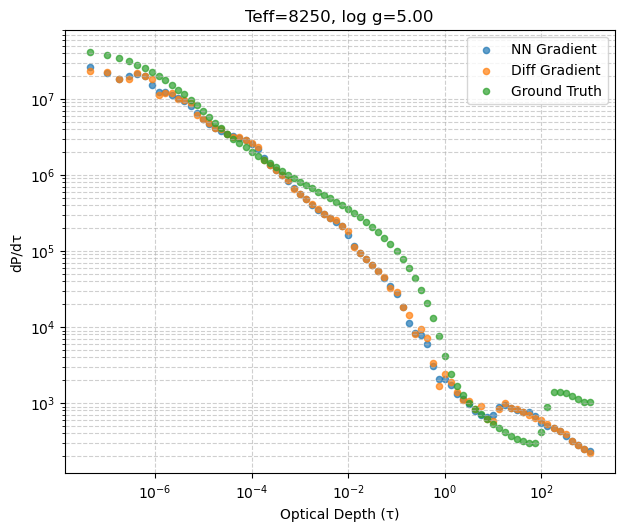

In [47]:
def compare_all_dP_dtau_methods(results_nn_grad, results_diff_grad, dP_dtau_ground_truth, sample_idx=0):
    """
    Compare dP/dtau from different calculation methods: 
    neural network gradient, differential gradient, and ground truth.
    
    Parameters:
        results_nn_grad (dict): Results from neural network gradient calculation
        results_diff_grad (dict): Results from differential gradient calculation
        dP_dtau_ground_truth (dict): Results from ground truth calculation
        sample_idx (int): Index of the sample to plot
        
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    plt.figure(figsize=(12, 8))
    
    # Plot neural network gradient
    tau_nn = results_nn_grad['tau'][sample_idx]
    dP_dtau_nn = results_nn_grad['dP_dtau'][sample_idx]
    plt.scatter(tau_nn, dP_dtau_nn, s=30, label='Neural Network Gradient', alpha=0.7)
    
    # Plot differential gradient
    tau_diff = results_diff_grad['tau'][sample_idx]
    dP_dtau_diff = results_diff_grad['dP_dtau'][sample_idx]
    plt.scatter(tau_diff, dP_dtau_diff, s=30, label='Differential Gradient', alpha=0.7)
    
    # Plot ground truth
    tau_gt = dP_dtau_ground_truth['tau'][sample_idx]
    dP_dtau_gt = dP_dtau_ground_truth['dP_dtau'][sample_idx]
    plt.scatter(tau_gt, dP_dtau_gt, s=30, label='Ground Truth', alpha=0.7)
    
    # Calculate error metrics for both methods
    from scipy.interpolate import interp1d
    
    # Find common tau range for all methods
    min_tau = max(np.min(tau_nn), np.min(tau_diff), np.min(tau_gt))
    max_tau = min(np.max(tau_nn), np.max(tau_diff), np.max(tau_gt))
    
    # Filter points within common range
    nn_mask = (tau_nn >= min_tau) & (tau_nn <= max_tau)
    diff_mask = (tau_diff >= min_tau) & (tau_diff <= max_tau)
    gt_mask = (tau_gt >= min_tau) & (tau_gt <= max_tau)
    
    # Interpolate ground truth to neural network tau points
    gt_interp = interp1d(tau_gt[gt_mask], dP_dtau_gt[gt_mask], 
                         bounds_error=False, fill_value="extrapolate")
    
    # Calculate error metrics for neural network method
    dP_dtau_gt_interp_nn = gt_interp(tau_nn[nn_mask])
    mse_nn = np.mean((dP_dtau_nn[nn_mask] - dP_dtau_gt_interp_nn)**2)
    mae_nn = np.mean(np.abs(dP_dtau_nn[nn_mask] - dP_dtau_gt_interp_nn))
    
    # Calculate error metrics for differential method
    dP_dtau_gt_interp_diff = gt_interp(tau_diff[diff_mask])
    mse_diff = np.mean((dP_dtau_diff[diff_mask] - dP_dtau_gt_interp_diff)**2)
    mae_diff = np.mean(np.abs(dP_dtau_diff[diff_mask] - dP_dtau_gt_interp_diff))
    
    # Set plot properties
    plt.xlabel('Optical Depth (τ)')
    plt.ylabel('dP/dτ')
    plt.title(f'Pressure Gradient Comparison\n'
              f'Teff={results_nn_grad["teff"][sample_idx]:.0f}, '
              f'log g={results_nn_grad["gravity"][sample_idx]:.2f}\n'
              f'NN Method: MSE={mse_nn:.2e}, MAE={mae_nn:.2e}\n'
              f'Diff Method: MSE={mse_diff:.2e}, MAE={mae_diff:.2e}')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    
    return plt

# Example usage:
fig = compare_all_dP_dtau_methods(results_nn_grad, results_diff_grad, dP_dtau_ground_truth, sample_idx=0)
# Create a grid of plots for multiple samples
def plot_multiple_comparisons(results_nn_grad, results_diff_grad, dP_dtau_ground_truth, 
                             sample_indices=None, rows=2, cols=2):
    """
    Create a grid of comparison plots for multiple samples
    
    Parameters:
        results_nn_grad (dict): Results from neural network gradient calculation
        results_diff_grad (dict): Results from differential gradient calculation
        dP_dtau_ground_truth (dict): Results from ground truth calculation
        sample_indices (list): Indices of samples to plot
        rows (int): Number of rows in the grid
        cols (int): Number of columns in the grid
    """
    # Determine valid sample indices
    if sample_indices is None:
        sample_indices = list(range(min(rows*cols, len(results_nn_grad['tau']))))
    else:
        # Filter out invalid indices
        max_idx_nn = len(results_nn_grad['tau']) - 1
        max_idx_diff = len(results_diff_grad['tau']) - 1
        max_idx_gt = len(dP_dtau_ground_truth['tau']) - 1
        max_valid_idx = min(max_idx_nn, max_idx_diff, max_idx_gt)
        
        # Keep only valid indices
        sample_indices = [idx for idx in sample_indices if idx <= max_valid_idx]
        
        if not sample_indices:
            raise ValueError("No valid sample indices provided. Check that your indices are within range.")
    
    # Create subplot grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5))
    axes = axes.flatten() if rows*cols > 1 else [axes]
    
    for i, idx in enumerate(sample_indices):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        # Plot neural network gradient
        tau_nn = results_nn_grad['tau'][idx]
        dP_dtau_nn = results_nn_grad['dP_dtau'][idx]
        ax.scatter(tau_nn, dP_dtau_nn, s=20, label='NN Gradient', alpha=0.7)
        
        # Plot differential gradient
        tau_diff = results_diff_grad['tau'][idx]
        dP_dtau_diff = results_diff_grad['dP_dtau'][idx]
        ax.scatter(tau_diff, dP_dtau_diff, s=20, label='Diff Gradient', alpha=0.7)
        
        # Plot ground truth
        tau_gt = dP_dtau_ground_truth['tau'][idx]
        dP_dtau_gt = dP_dtau_ground_truth['dP_dtau'][idx]
        ax.scatter(tau_gt, dP_dtau_gt, s=20, label='Ground Truth', alpha=0.7)
        
        # Set plot properties
        ax.set_xlabel('Optical Depth (τ)')
        ax.set_ylabel('dP/dτ')
        ax.set_title(f'Teff={results_nn_grad["teff"][idx]:.0f}, log g={results_nn_grad["gravity"][idx]:.2f}')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, which='both', linestyle='--', alpha=0.6)
        ax.legend()
    
    # Handle case where we have fewer samples than subplots
    for i in range(len(sample_indices), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    return fig

# Example usage with explicit validation:
valid_indices = []
for i in sample_indices:
    if (i < len(results_nn_grad['tau']) and 
        i < len(results_diff_grad['tau']) and 
        i < len(dP_dtau_ground_truth['tau'])):
        valid_indices.append(i)

fig_grid = plot_multiple_comparisons(
    results_nn_grad, 
    results_diff_grad, 
    dP_dtau_ground_truth, 
    sample_indices=valid_indices
)